In [40]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
csv_loc = "/content/drive/MyDrive/ML dataset/hotel recommendation.csv"
hotel_data = pd.read_csv(csv_loc)

In [43]:
display(hotel_data.head())

,Title,Price,Location,Offer,Rating,Review,No_of_ratings,Discount,Special,City,From_Date,To_Date
0,Fortune Select JP Cosmos - Member ITC Hotel Group,"₹ 3,188",Vasanth Nagar | 4.2 km from Kempegowda Bus Sta...,NaN,3.9,(Good),2384.0,15%,"['Lounge', 'Butler Services', 'Free Parking']",Bangalore,09-08-2021,11-08-2021
1,Vividus,"₹ 4,133",Gandhi Nagar | 2.0 km from Kempegowda Bus Station,Exclusive Offer - HDFC Credit Card Users. Get ...,4.4,(Very Good),676.0,36%,"['Free Parking', 'Business Centre', 'Conferenc...",Bangalore,09-08-2021,11-08-2021
2,Bannerghatta Nature Camp by Jungle Lodges,"₹ 5,253",NaN,Exclusive Offer - HDFC Credit Card Users. Get ...,4.7,(Excellent),48.0,14%,"['Kitchenette', 'Outdoor Sports', 'Lawn']",Bangalore,09-08-2021,11-08-2021
3,Starlit Suites,"₹ 2,094",Bommasandra,Exclusive Offer - HDFC Credit Card Users. Get ...,4.2,(Very Good),362.0,25%,"['Lounge', 'Free Parking', 'Business Centre']",Bangalore,09-08-2021,11-08-2021
4,The Park Bangalore,"₹ 2,364",Ulsoor,Exclusive Offer - HDFC Credit Card Users. Get ...,4.0,(Very Good),2649.0,32%,"['Lounge', 'Free Parking', 'Business Centre']",Bangalore,09-08-2021,11-08-2021


In [44]:
hotel_data.shape

(8050, 12)

In [45]:
hotel_data.columns

Index(['Title', 'Price', 'Location', 'Offer', 'Rating', 'Review',
       'No_of_ratings', 'Discount', 'Special', 'City', 'From_Date', 'To_Date'],
      dtype='object')

In [46]:
hotel_data.describe()

,Rating,No_of_ratings
count,6916.000000,6916.000000
mean,3.706564,261.624783
std,0.686277,535.053410
min,1.000000,1.000000
25%,3.300000,17.000000
50%,3.800000,73.000000
75%,4.200000,261.250000
max,5.000000,10005.000000


In [47]:
hotel_data.isnull().sum()

,0
Title,0
Price,0
Location,49
Offer,703
Rating,1134
Review,1935
No_of_ratings,1134
Discount,368
Special,0
City,0


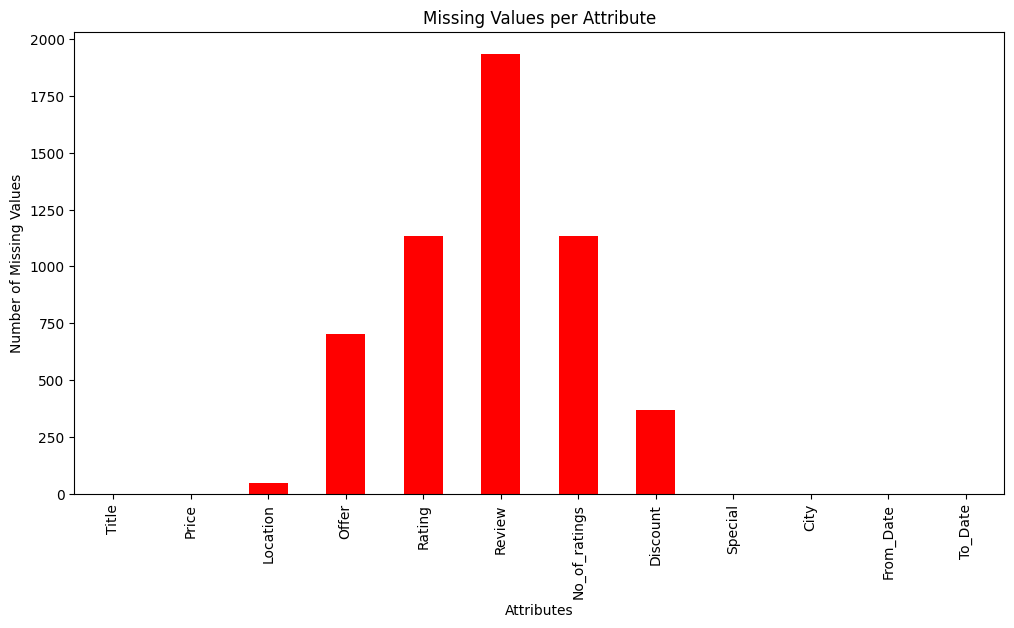

In [48]:
missing_values = hotel_data.isnull().sum()

plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='red')
plt.title('Missing Values per Attribute')
plt.xlabel('Attributes')
plt.ylabel('Number of Missing Values')
plt.show()

In [49]:
# Clean numeric columns
hotel_data['Price'] = hotel_data['Price'].str.replace(r'[^\d.]', '', regex=True).astype(float)
hotel_data['Discount'] = hotel_data['Discount'].str.replace(r'[^\d.]', '', regex=True).astype(float)

In [50]:
# Handle missing values by imputing median
imputer = SimpleImputer(strategy='median')
numeric_columns = ['Price', 'Rating', 'No_of_ratings', 'Discount']
hotel_data[numeric_columns] = imputer.fit_transform(hotel_data[numeric_columns])

In [51]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(hotel_data[numeric_columns])

In [52]:
hotel_data.isnull().sum()

,0
Title,0
Price,0
Location,49
Offer,703
Rating,0
Review,1935
No_of_ratings,0
Discount,0
Special,0
City,0


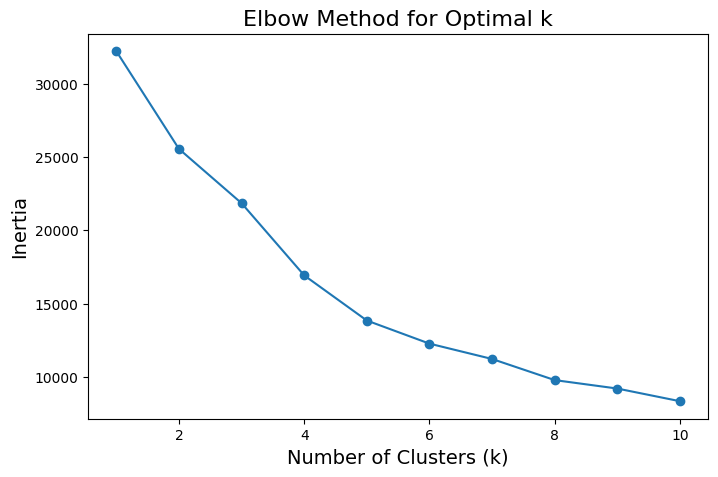

In [53]:
from sklearn.cluster import KMeans


# Elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
#plt.grid(True)
plt.show()


In [54]:
# Apply k-Means with the chosen k (e.g., k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data
hotel_data['Cluster'] = clusters

# Summary of clusters
print(hotel_data.groupby('Cluster')[numeric_columns].mean())


               Price    Rating  No_of_ratings   Discount
Cluster                                                 
0        1704.764457  3.704748     136.979314  48.246356
1        1601.468852  2.693115      81.821311  20.018033
2        1987.682938  3.992208     177.869514  14.896973
3        5763.633484  3.998643    1681.221719  24.147059


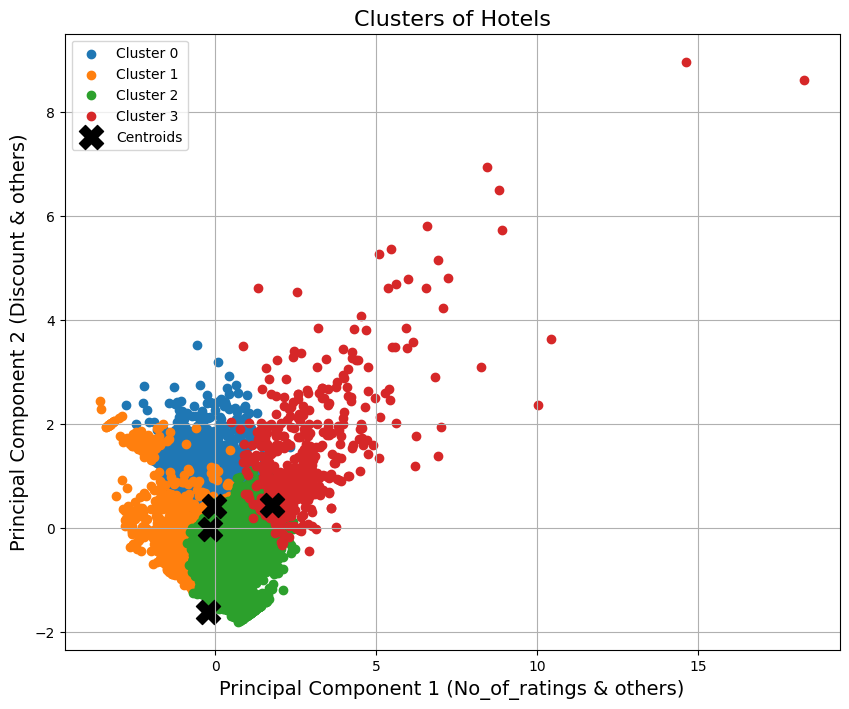

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Get feature contributions to each principal component
pca_feature_importance = pca.components_

# Identify top contributing features for each component
component_1_features = sorted(zip(numeric_columns, pca_feature_importance[0]), key=lambda x: abs(x[1]), reverse=True)
component_2_features = sorted(zip(numeric_columns, pca_feature_importance[1]), key=lambda x: abs(x[1]), reverse=True)

# Use the top contributing feature for each PCA component as axis labels
x_label = f'Principal Component 1 ({component_1_features[0][0]} & others)'
y_label = f'Principal Component 2 ({component_2_features[0][0]} & others)'

# Scatter plot of clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    plt.scatter(reduced_data[clusters == cluster, 0], reduced_data[clusters == cluster, 1], label=f'Cluster {cluster}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', marker='X', label='Centroids')

# Add new axis labels
plt.title('Clusters of Hotels', fontsize=16)
plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [56]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(scaled_data, clusters)
print(f'Silhouette Score: {sil_score:.2f}')


Silhouette Score: 0.34


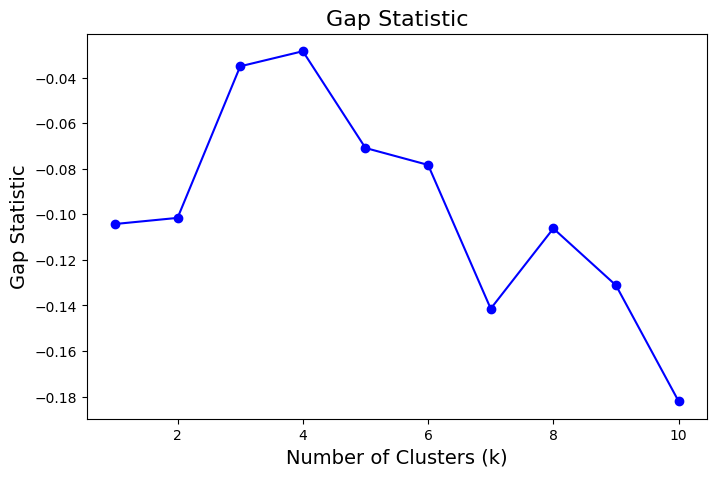

In [57]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def gap_statistic(X, n_refs=10, max_clusters=10):
    """
    Compute the gap statistic for k-means clustering.
    """
    gaps = []
    sds = []
    random_reference = np.random.random_sample(size=X.shape)

    for k in range(1, max_clusters + 1):
        # Fit k-means and calculate within-cluster sum of squares
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
        Wk = np.log(np.sum(np.min(pairwise_distances(X, kmeans.cluster_centers_, metric='euclidean')**2, axis=1)))

        # Generate random reference data and calculate Wk for it
        ref_Wks = []
        for _ in range(n_refs):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(random_reference)
            ref_Wks.append(np.log(np.sum(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))))

        # Gap statistic
        ref_Wk_mean = np.mean(ref_Wks)
        ref_Wk_std = np.std(ref_Wks)
        gap = ref_Wk_mean - Wk
        gaps.append(gap)
        sds.append(ref_Wk_std)

    return gaps, sds

# Example scaled_data (replace this with your dataset)
# Ensure 'scaled_data' is a NumPy array or similar format.
scaled_data = np.random.rand(100, 2)  # Example random dataset for demonstration

# Calculate gap statistics
gaps, sds = gap_statistic(scaled_data, n_refs=10, max_clusters=10)

# Plot the gap statistic
plt.figure(figsize=(8, 5))
plt.errorbar(range(1, 11), gaps, yerr=sds, fmt='-o', color='b')
plt.title('Gap Statistic', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Gap Statistic', fontsize=14)

plt.show()


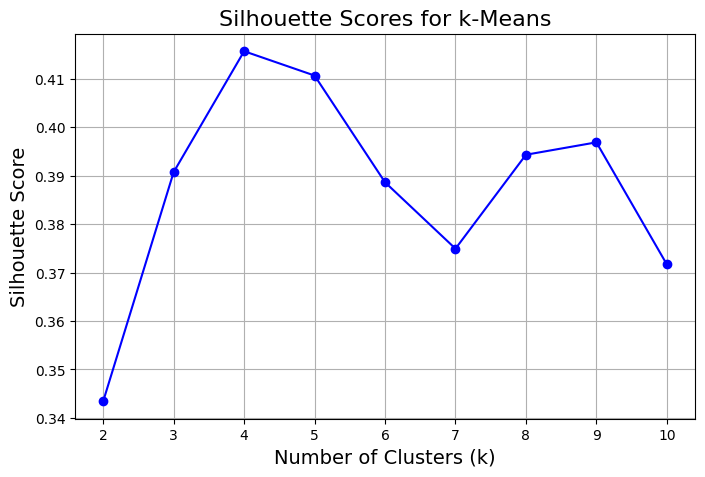

In [58]:
from sklearn.metrics import silhouette_score

# Perform cross-validation using silhouette score
def cross_validation_kmeans(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):  # Silhouette requires at least 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    return silhouette_scores

# Calculate silhouette scores
silhouette_scores = cross_validation_kmeans(scaled_data, max_clusters=10)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for k-Means', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True)
plt.show()


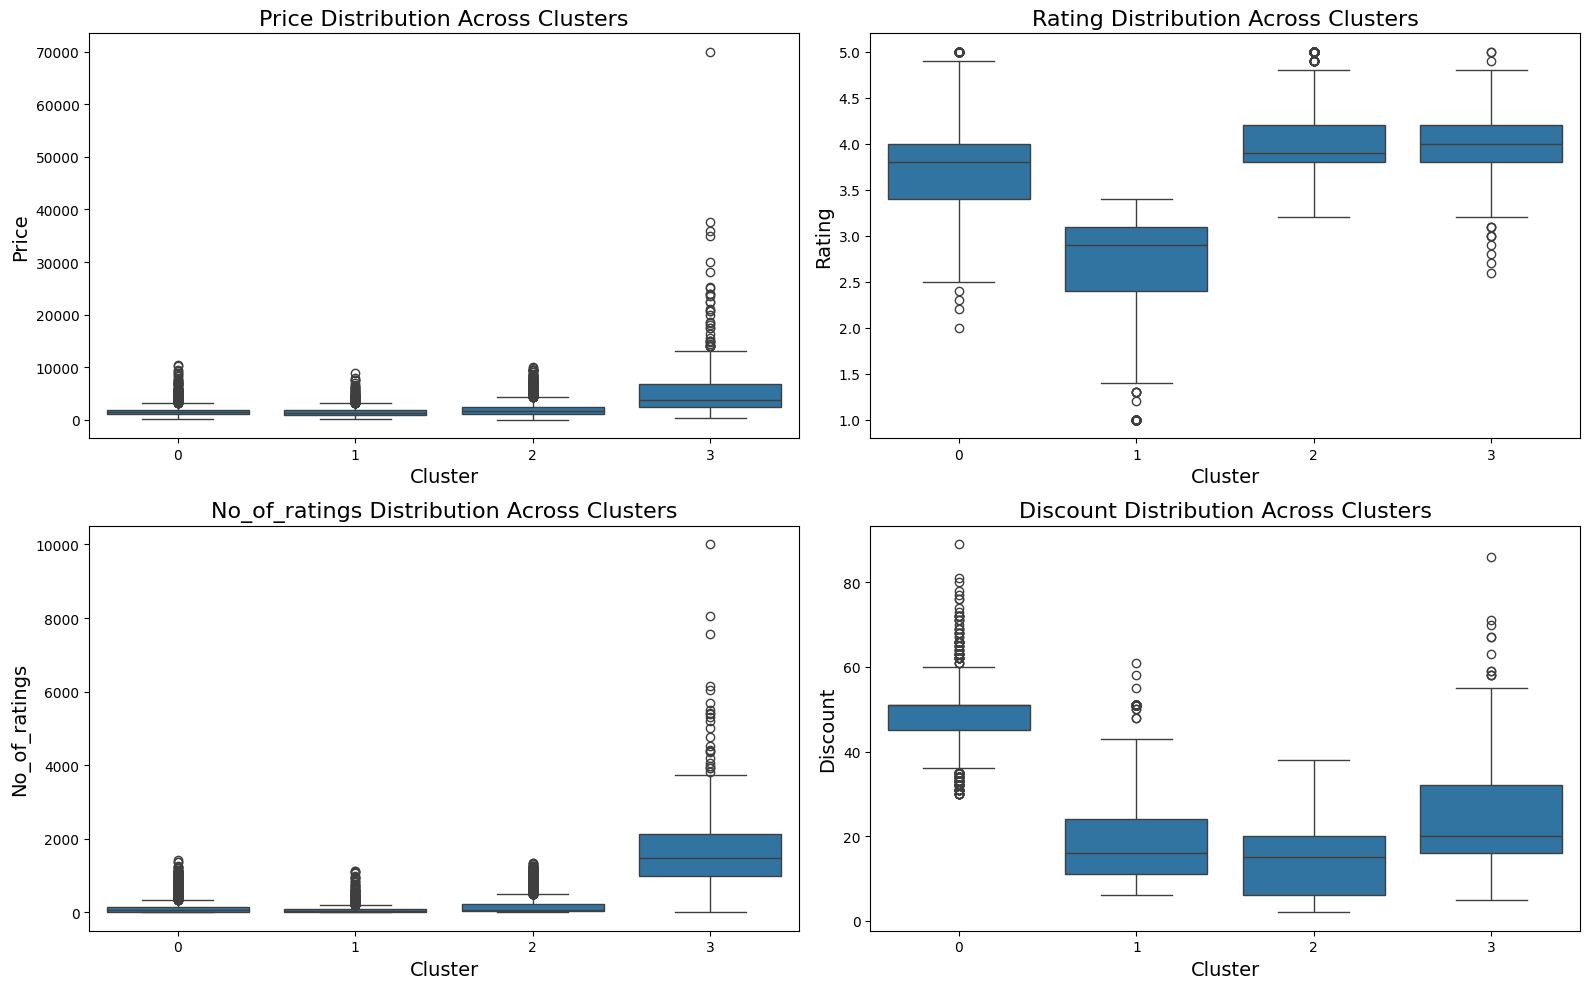

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `hotel_data` already contains a 'Cluster' column from the k-means clustering results

# List of numerical columns to visualize
columns_to_plot = ['Price', 'Rating', 'No_of_ratings', 'Discount']

# Create box plots for each feature
plt.figure(figsize=(16, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    sns.boxplot(x='Cluster', y=column, data=hotel_data)
    plt.title(f'{column} Distribution Across Clusters', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel(column, fontsize=14)

plt.tight_layout()
plt.show()
